# Tree Data Export for DT Explainer

lucsan - Sept 2021

In [1]:
import pandas as pd
import re
import numpy as np
import graphviz
import six
import json
import random

import sklearn
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Plotting util function
def plot_data(data, features=["Height", "Diameter"], mirror=False):
    if mirror:
        features = features[::-1]
    cols = ["tab:red", "tab:blue", "tab:green"]
    dict_cols_fam = {k: v for (k, v) in zip(data.Family.unique(), cols)}

    fig, ax = plt.subplots()
    grouped_fam = data.groupby('Family')
    for key, group in grouped_fam:
        group.plot(ax=ax, kind='scatter', x=features[0], y=features[1], figsize=(8,7), 
                   label=key, color=dict_cols_fam[key])
    plt.show()


## Read data and fit decision tree

In [3]:
# Run this cell if fitting it from file data (rather than fresh generated data)
dfm = pd.read_csv("data/data_for_tree_Oct22.csv")
#dfm = pd.read_csv("data/data_for_tree_Sept23.csv")

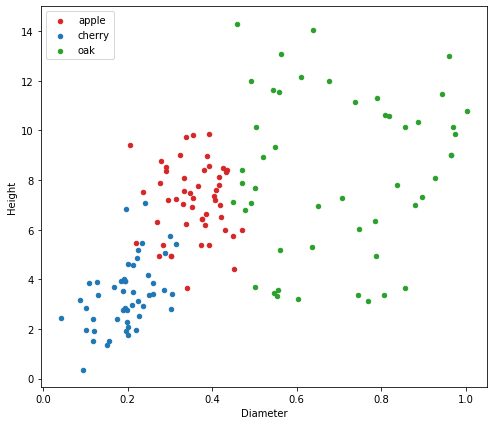

In [4]:
plot_data(dfm, mirror=True)

In [5]:
features = ["Diameter", "Height"]
X = dfm[features]
y = dfm["Family"]

In [6]:
dt = tree.DecisionTreeClassifier(max_depth=4, criterion="entropy", min_samples_leaf=4)
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=4)

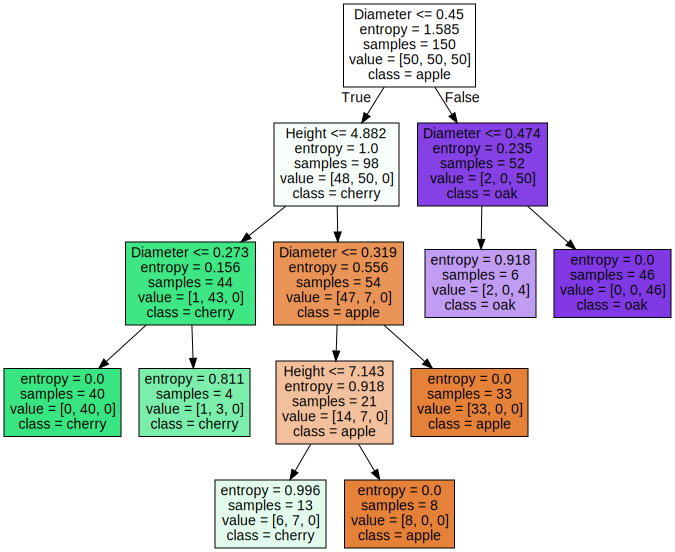

In [7]:
# DOT data
class_names = ["apple", "cherry", "oak"]
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=features,  
                                class_names=class_names,
                                filled=True)

# Draw graph - scroll to the right to see the root of the tree
graph = graphviz.Source(dot_data, format="png") 
graph


## Visualize decision boundaries

In [8]:
def visualize_classifier(model, data, ax=None, cmap='rainbow', mirror="False"):
    ax = ax or plt.gca()
    
    features = ["Height", "Diameter"]
    label = "Family"
    if mirror: 
        features = features[::-1]
    X = data[features].to_numpy()
    y = LabelEncoder().fit_transform(data["Family"].to_numpy())
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                         clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    #ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)
                           

    ax.set(xlim=xlim, ylim=ylim)
    
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)
    
    return model

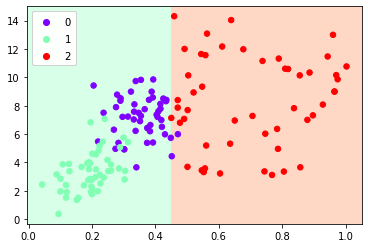

In [9]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=1, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=4), dfm, mirror=True)

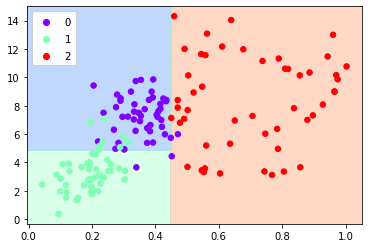

In [10]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=2, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=4), dfm, mirror=True)

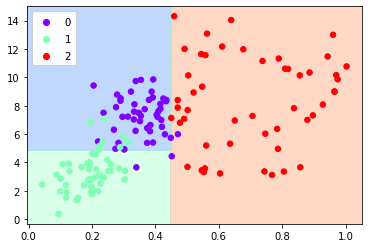

In [11]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=3, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=4), dfm, mirror=True)

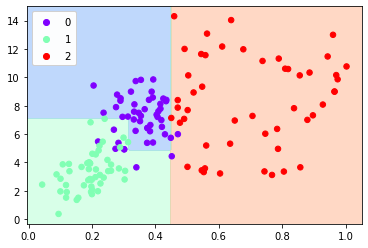

In [12]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=4), dfm, mirror=True)

## Data and Tree export

In [13]:
def export_data(data, fields=["Height", "Diameter", "Family"]):
    
    out = []
    for i, row in data.iterrows():
        out.append({ "Height": row.Height, "Diameter": row.Diameter, "Family": row.Family })
        
    return out

In [14]:
def shorten_name(text):
    text = text.replace("Diameter", "D")
    text = text.replace("Height", "H")
    return text

def export_dict(decision_tree, feature_names=None, round_=2, shorten=False):
    js = {}
    def node2str(tree, node_id, criterion):
        if not isinstance(criterion, six.string_types):
            criterion = "entropy"
        value = tree.tree_.value[node_id]
        if tree.tree_.n_outputs == 1:
            value = value[0, :]
        if tree.tree_.children_left[node_id] == sklearn.tree._tree.TREE_LEAF:
            # if end node
            return {"id": str(node_id),
                    "entropy": str(round(tree.tree_.impurity[node_id], 3)), #round with 3 decimals
                    "samples": str(tree.tree_.n_node_samples[node_id]),
                    "value": str(value),
                    "class":  str(value.argmax(axis=0))
                   } 
        else:
            if feature_names is not None:
                feature = feature_names[tree.tree_.feature[node_id]]
            else:
                feature = tree.tree_.feature[node_id]
            name = f"{feature} ≤ {round(tree.tree_.threshold[node_id], round_)}"
            return {"id": str(node_id),
                    'children':[],
                    "name": shorten_name(name) if shorten else name,
                    "entropy": str(round(tree.tree_.impurity[node_id], 3)),
                    "samples": str(tree.tree_.n_node_samples[node_id])
                   } 
    def recurse(tree, node_id, criterion, parent=None):
        left_child = tree.tree_.children_left[node_id]
        right_child = tree.tree_.children_right[node_id]
        js = node2str(tree, node_id, criterion)
        # if not end node, append left and right to children
        if left_child != sklearn.tree._tree.TREE_LEAF: 
            js['children'].append(recurse(tree, left_child, criterion=criterion, parent=node_id))
            js['children'].append(recurse(tree, right_child,criterion=criterion,parent=node_id))
        return js
    if isinstance(decision_tree, sklearn.tree.DecisionTreeClassifier):
        js = recurse(decision_tree, 0, criterion="entropy")
    else:
        js = recurse(decision_tree.tree_, 0, criterion=decision_tree.criterion)
    return js

In [15]:
# Utilities to prune decision nodes that end up in the same class

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == sklearn.tree._tree.TREE_LEAF and 
            inner_tree.children_right[index] == sklearn.tree._tree.TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = sklearn.tree._tree.TREE_LEAF
        inner_tree.children_right[index] = sklearn.tree._tree.TREE_LEAF
        print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    print(f"Decisions: {decisions}")
    prune_index(mdl.tree_, decisions)

In [16]:
def left_right_child(node):
    if ("children" in node[0]) and ("children" in node[1]):
        return 2
    elif "children" in node[0]:
        return 0
    elif "children" in node[1]:
        return 1
    else:
        return -1
    
def get_split_rect_terminal(node, class_names, depth, xlim, ylim, r=2):
    # Get split variable and split value
    feature, value = node["name"].split(" ≤ ")
    
    split_rect = []
    
    # Terminal node
    if left_right_child(node["children"]) == -1: 
        
        # First right child
        prediction = class_names[int(node["children"][1]["class"])]
            
        if feature == "Diameter":
            x1, x2, y1, y2 = float(value), xlim[1], ylim[1], ylim[0]
        elif feature == "Height":
            x1, x2, y1, y2 = xlim[0], xlim[1], ylim[1], float(value)
        out = {"name": node["name"],
                   "feature": feature,
                   "value": float(value),
                   "x1": round(x1, r),
                   "x2": round(x2, r),
                   "y1": round(y1, r),
                   "y2": round(y2, r),
                   "depth": depth,
                   "prediction": prediction
                  }
        split_rect.append(out)
        
        # Now left child
        prediction = class_names[int(node["children"][0]["class"])]
            
        if feature == "Diameter":
            x1, x2, y1, y2 = xlim[0], float(value), ylim[1], ylim[0]
        elif feature == "Height":
            x1, x2, y1, y2 = xlim[0], xlim[1], float(value), ylim[0]
        out = {"name": node["name"],
                   "feature": feature,
                   "value": float(value),
                   "x1": round(x1, r),
                   "x2": round(x2, r),
                   "y1": round(y1, r),
                   "y2": round(y2, r),
                   "depth": depth,
                   "prediction": prediction
                  }
        split_rect.append(out)
        
    return split_rect

In [17]:
def get_split_rect(node, class_names, depth, xlim=(0, 1.3), ylim=(0, 16), r=2):
    # Get split variable and split value
    feature, value = node["name"].split(" ≤ ")
    
    # Find out if the node has left or right children
    ind_children = left_right_child(node["children"])
    
    # If only one has children, the other is leaf, get its value
    if ind_children in (0, 1):
        other = int(not bool(ind_children))
        prediction = class_names[int(node["children"][other]["class"])]
    
        if feature == "Diameter":
            if ind_children == 0:
                x1, x2, y1, y2 = float(value), xlim[1], ylim[1], ylim[0]
                left_rect = (xlim[0], float(value), ylim[0], ylim[1])
            elif ind_children == 1:
                x1, x2, y1, y2 = xlim[0], float(value), ylim[1], ylim[0]
                left_rect = (float(value), xlim[1], ylim[0], ylim[1])
        elif feature == "Height":
            if ind_children == 0:
                x1, x2, y1, y2 = xlim[0], xlim[1], ylim[1], float(value)
                left_rect = (xlim[0], xlim[1], ylim[0], float(value))
            elif ind_children == 1:
                x1, x2, y1, y2 = xlim[0], xlim[1], float(value), ylim[0]
                left_rect = (xlim[0], xlim[1], float(value), ylim[1])
        else:
            print("Unknown feature! Stop")
    
        out = {"name": node["name"],
               "feature": feature,
               "value": float(value),
               "x1": round(x1, r),
               "x2": round(x2, r),
               "y1": round(y1, r),
               "y2": round(y2, r),
               "depth": depth,
               "prediction": prediction
              }
        
    # If both have children we need to create two rectangles. Don't panic
    if ind_children == 2:
        raise ValueError("Not Implemented")
        
    return out, left_rect

In [18]:
def traverse_tree(exported_tree, class_names):
    splitRecs = []
    
    node = exported_tree
    
    depth = 1
    xlim = (0, 1.3)
    ylim = (0, 16)
    
    while left_right_child(node["children"]) != -1:
        split_rect, left_rect = get_split_rect(node, class_names, depth, xlim=xlim, ylim=ylim)
        splitRecs.append(split_rect)
        
        depth += 1
        xlim = left_rect[:2]
        ylim = left_rect[2:]
        
        # Figure out where children are, continue there
        ind_children = left_right_child(node["children"])
        node = node["children"][ind_children]
        
    # Terminal node
    splitRecs.extend(get_split_rect_terminal(node, class_names, depth, xlim=xlim, ylim=ylim))   
                
    return splitRecs

## Run the next 3 cells to get the unperturbed data for data.js

In [19]:
# This data exported goes into: 
# export const scatterData =
pprint(export_data(dfm), width=90)

[{'Diameter': 0.2837053102864515, 'Family': 'apple', 'Height': 5.37813468427625},
 {'Diameter': 0.3320759060476357, 'Family': 'apple', 'Height': 7.026770998894442},
 {'Diameter': 0.433734730040961, 'Family': 'apple', 'Height': 8.315904765022157},
 {'Diameter': 0.340192927284109, 'Family': 'apple', 'Height': 3.6498932725961946},
 {'Diameter': 0.4208133542045583, 'Family': 'apple', 'Height': 6.5075162679197},
 {'Diameter': 0.2899813396901569, 'Family': 'apple', 'Height': 8.348660609314413},
 {'Diameter': 0.2052828604624424, 'Family': 'apple', 'Height': 9.42195022772238},
 {'Diameter': 0.2760452936212325, 'Family': 'apple', 'Height': 7.896332074805976},
 {'Diameter': 0.323141279464649, 'Family': 'apple', 'Height': 8.991058052538946},
 {'Diameter': 0.2794179616731622, 'Family': 'apple', 'Height': 8.779807373618395},
 {'Diameter': 0.3377198782721952, 'Family': 'apple', 'Height': 6.224027369482324},
 {'Diameter': 0.4162146742257026, 'Family': 'apple', 'Height': 7.786999135105338},
 {'Diamete

In [20]:
# This data exported goes into: 
# export const treeData =
features = ["Diameter", "Height"]
prune_duplicate_leaves(dt)
tt = export_dict(dt, features)
tt

Decisions: [0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 2, 2]
Pruned 2
Pruned 10


{'id': '0',
 'children': [{'id': '1',
   'children': [{'id': '2',
     'entropy': '0.156',
     'samples': '44',
     'value': '[ 1. 43.  0.]',
     'class': '1'},
    {'id': '5',
     'children': [{'id': '6',
       'children': [{'id': '7',
         'entropy': '0.996',
         'samples': '13',
         'value': '[6. 7. 0.]',
         'class': '1'},
        {'id': '8',
         'entropy': '0.0',
         'samples': '8',
         'value': '[8. 0. 0.]',
         'class': '0'}],
       'name': 'Height ≤ 7.14',
       'entropy': '0.918',
       'samples': '21'},
      {'id': '9',
       'entropy': '0.0',
       'samples': '33',
       'value': '[33.  0.  0.]',
       'class': '0'}],
     'name': 'Diameter ≤ 0.32',
     'entropy': '0.556',
     'samples': '54'}],
   'name': 'Height ≤ 4.88',
   'entropy': '1.0',
   'samples': '98'},
  {'id': '10',
   'entropy': '0.235',
   'samples': '52',
   'value': '[ 2.  0. 50.]',
   'class': '2'}],
 'name': 'Diameter ≤ 0.45',
 'entropy': '1.585',
 'sam

In [21]:
# This data exported goes into: 
# export const splitRects = 
traverse_tree(tt, class_names)

[{'name': 'Diameter ≤ 0.45',
  'feature': 'Diameter',
  'value': 0.45,
  'x1': 0.45,
  'x2': 1.3,
  'y1': 16,
  'y2': 0,
  'depth': 1,
  'prediction': 'oak'},
 {'name': 'Height ≤ 4.88',
  'feature': 'Height',
  'value': 4.88,
  'x1': 0,
  'x2': 0.45,
  'y1': 4.88,
  'y2': 0,
  'depth': 2,
  'prediction': 'cherry'},
 {'name': 'Diameter ≤ 0.32',
  'feature': 'Diameter',
  'value': 0.32,
  'x1': 0.32,
  'x2': 0.45,
  'y1': 16,
  'y2': 4.88,
  'depth': 3,
  'prediction': 'apple'},
 {'name': 'Height ≤ 7.14',
  'feature': 'Height',
  'value': 7.14,
  'x1': 0,
  'x2': 0.32,
  'y1': 16,
  'y2': 7.14,
  'depth': 4,
  'prediction': 'apple'},
 {'name': 'Height ≤ 7.14',
  'feature': 'Height',
  'value': 7.14,
  'x1': 0,
  'x2': 0.32,
  'y1': 7.14,
  'y2': 4.88,
  'depth': 4,
  'prediction': 'cherry'}]

In [32]:
from collections import deque

def breadth_first_traversal(tree):
    stack = deque()
    stack.append(0)

    while stack:
        current_node = stack.popleft()

        yield current_node

        left_child = tree.children_left[current_node]
        if left_child >= 0:
            stack.append(left_child)

        right_child = tree.children_right[current_node]
        if right_child >= 0:
            stack.append(right_child)

def entropy_data(clf, features):
    out = list()
    counter = 0
    for i in breadth_first_traversal(clf.tree_):
        if not is_leaf(clf.tree_, i):
            thr = round(clf.tree_.threshold[i], 2)
            data = {"id": counter, 
                    "entropy": str(round(clf.tree_.impurity[i], 3)),
                    "samples": int(clf.tree_.n_node_samples[i]),
                    "nApple": int(clf.tree_.value[i][0][0]),
                    "nCherry": int(clf.tree_.value[i][0][1]),
                    "nOak": int(clf.tree_.value[i][0][2]),
                    "name": f"{features[clf.tree_.feature[i]]} \u2264 {thr}"}
        else:
            data = {"id": counter, 
                    "entropy": str(round(clf.tree_.impurity[i], 3)),
                    "samples": int(clf.tree_.n_node_samples[i]),
                    "nApple": int(clf.tree_.value[i][0][0]),
                    "nCherry": int(clf.tree_.value[i][0][1]),
                    "nOak": int(clf.tree_.value[i][0][2]),
                    "class": clf.classes_[np.argmax(clf.tree_.value[i])]}
        out.append(data)
        counter += 1
        
    return out
    

In [33]:
entropy_data(dt, features)

[{'id': 0,
  'entropy': '1.585',
  'samples': 150,
  'nApple': 50,
  'nCherry': 50,
  'nOak': 50,
  'name': 'Diameter ≤ 0.45'},
 {'id': 1,
  'entropy': '1.0',
  'samples': 98,
  'nApple': 48,
  'nCherry': 50,
  'nOak': 0,
  'name': 'Height ≤ 4.88'},
 {'id': 2,
  'entropy': '0.235',
  'samples': 52,
  'nApple': 2,
  'nCherry': 0,
  'nOak': 50,
  'class': 'oak'},
 {'id': 3,
  'entropy': '0.156',
  'samples': 44,
  'nApple': 1,
  'nCherry': 43,
  'nOak': 0,
  'class': 'cherry'},
 {'id': 4,
  'entropy': '0.556',
  'samples': 54,
  'nApple': 47,
  'nCherry': 7,
  'nOak': 0,
  'name': 'Diameter ≤ 0.32'},
 {'id': 5,
  'entropy': '0.918',
  'samples': 21,
  'nApple': 14,
  'nCherry': 7,
  'nOak': 0,
  'name': 'Height ≤ 7.14'},
 {'id': 6,
  'entropy': '0.0',
  'samples': 33,
  'nApple': 33,
  'nCherry': 0,
  'nOak': 0,
  'class': 'apple'},
 {'id': 7,
  'entropy': '0.996',
  'samples': 13,
  'nApple': 6,
  'nCherry': 7,
  'nOak': 0,
  'class': 'cherry'},
 {'id': 8,
  'entropy': '0.0',
  'samples

In [35]:
data = {"scatterData": export_data(dfm), 
        "treeData": tt, 
        "splitRects": traverse_tree(tt, class_names),
        "entropyTreeData": entropy_data(dt, features)}
with open("data/data_unperturbed.json", "w") as outfile:
    json.dump(data, outfile, indent=4)

## Perturb Data

In [74]:
def is_in_bounds(h, d, hlim, dlim): 
    return (h >= hlim[0]) & (h <= hlim[1]) & (d >= dlim[0]) & (d <= dlim[1])

def perturb_data(data, sigma=1):
    
    df = data.copy(deep=True)
    
    max_h = df.Height.max()
    min_h = df.Height.min()
    max_d = df.Diameter.max()
    min_d = df.Diameter.min()
    
    ind = random.randint(0, len(df)-1)
    new_height = random.gauss(df.loc[ind, "Height"], sigma)
    new_diameter = random.gauss(df.loc[ind, "Diameter"], sigma)
    
    while not is_in_bounds(new_height, new_diameter, (min_h, max_h), (min_d, max_d)):
        ind = random.randint(0, len(df)-1)
    
        # Perturb height and dimension with gaussian 
        new_height = random.gauss(df.loc[ind, "Height"], sigma)
        new_diameter = random.gauss(df.loc[ind, "Diameter"], sigma)
        
    df.loc[ind, "Height"] = new_height
    df.loc[ind, "Diameter"] = new_diameter
    
    return df

def perturb_recursive(data, n):
    for i in range(n):
        data = perturb_data(data)
    return data

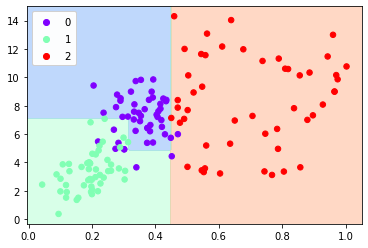

In [75]:
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=4), dfm, mirror=True)

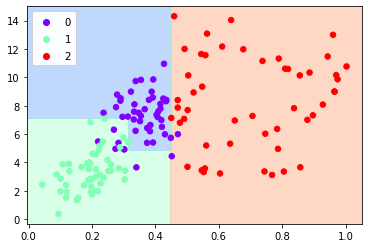

In [78]:
pert_data = perturb_data(dfm)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=4), pert_data, mirror=True)

## Perturb 10% data points

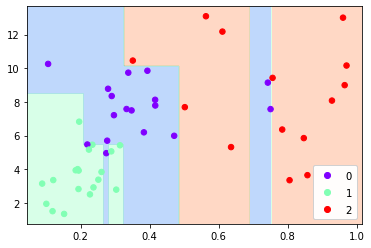

In [106]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(1,1)), pert_data.sample(n=50), mirror=True)

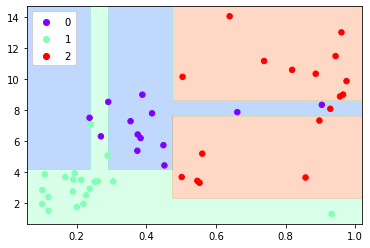

In [108]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(1, 1)), pert_data.sample(n=50), mirror=True)

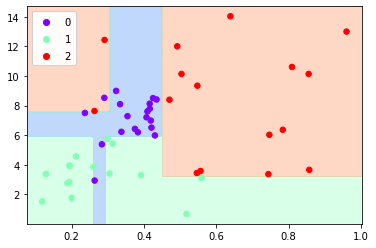

In [109]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(1, 1)), pert_data.sample(n=50), mirror=True)

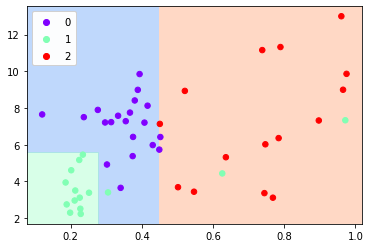

In [100]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(2,4)), pert_data.sample(n=50), mirror=True)

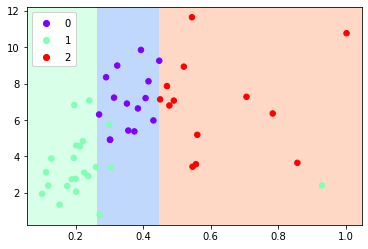

In [101]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(2,4)), pert_data.sample(n=50), mirror=True)

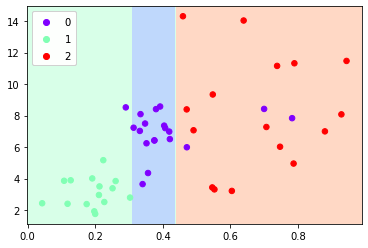

In [102]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(2,4)), pert_data.sample(n=50), mirror=True)

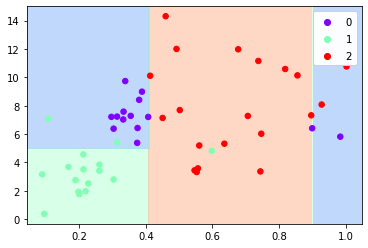

In [103]:
pert_data = perturb_recursive(dfm, 15)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, 
                                                               criterion="entropy", 
                                                               min_samples_leaf=random.randint(2,4)), pert_data.sample(n=50), mirror=True)

In [118]:
# Utilities to get rectangles to make scatter plot

import numpy as np
from collections import deque
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree as ctree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right


def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i])
            queue.extend([l, r])
    return aabbs


def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    return rectangles

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['b', 'r', 'g'][int(rect[4])]
        print(rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.3)
        plt.gca().add_artist(rp)
        
def split_recs_static(clf, class_names, r=2):
    rectangles = decision_areas(clf, maxrange=(0, 1.3, 0, 16))
    splitRecs = []
    for rect in rectangles:
        if (rect[0]==0) and (rect[1]==1.3) and (rect[3]==16) and (rect[2]==0):
            print("Skipping")
            continue
        splitRecs.append({
            "x1": round(rect[0], r),
            "x2": round(rect[1], r),
            "y1": round(rect[3], r),
            "y2": round(rect[2], r),
#            "max_depth": clf.tree_.max_depth,
            "prediction": class_names[int(rect[4])]
        })
    return splitRecs

## Export perturbed data

In [128]:
def data_exporter(data, perturbed=False):
    
    # Exported data
    outdata = export_data(data)
    
    # Train tree
    #features = ["Height", "Diameter"]
    features = ["Diameter", "Height"]
    X = data[features]
    y = data["Family"]
    clf = tree.DecisionTreeClassifier(max_depth=4, criterion="entropy", min_samples_leaf=random.randint(2,4))
    clf.fit(X, y)
    
    # Exported tree
    prune_duplicate_leaves(clf)
    tt = export_dict(clf, features, shorten=True)
    # Unperturbed data
    if not perturbed:
        splitRects = traverse_tree(tt, class_names)
    else:
        # Perturbed data:
        splitRects = split_recs_static(clf, class_names)
    
    out = {"scatterData": outdata, "maxDepth": clf.tree_.max_depth, "treeData": tt, "splitRects": splitRects}
    return out

In [131]:
# Export 6 perturbed data sets
# We perturb 10% points per data set out of the 150 original (that's 15) and then sample 50 points total
# This data exported goes into: 
# export const dataPerturbed = 
data = {}
for i in range(8):
    data[f"data_{i}"] = data_exporter(perturb_recursive(dfm, 8), perturbed=True)
pprint(data, width=200)

Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
{'data_0': {'maxDepth': 4,
            'scatterData': [{'Diameter': 0.2837053102864515, 'Family': 'apple', 'Height': 5.378134684276249},
                            {'Diameter': 0.33207590604763576, 'Family': 'apple', 'Height': 7.026770998894443},
                            {'Diameter': 0.43373473004096097, 'Family': 'apple', 'Height': 8.315904765022157},
                            {'Diameter': 0.4133499426638638, 'Family': 'apple', 'Height': 2.9494958941177103},
                            {'Diameter': 0.4

In [36]:
data.keys()

dict_keys(['data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11', 'data_12', 'data_13', 'data_14', 'data_15', 'data_16', 'data_17', 'data_18', 'data_19', 'data_20', 'data_21', 'data_22', 'data_23', 'data_24', 'data_25', 'data_26', 'data_27', 'data_28', 'data_29'])

In [132]:
with open("data/data_perturbed.json", "w") as outfile:
    json.dump(data, outfile, indent=4)

### Double check

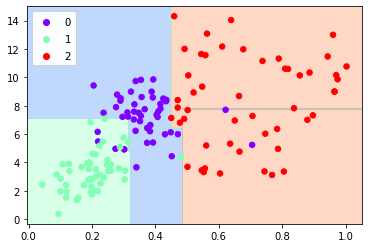

In [133]:
pert_data = perturb_recursive(dfm, 10)
trained_clf = visualize_classifier(tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), pert_data, mirror=True)

In [134]:
rectangles = decision_areas(trained_clf, maxrange=(0, 1.3, 0, 16))
rectangles

array([[ 0.        ,  0.32248983,  0.        ,  4.76519012,  1.        ],
       [ 0.32248983,  0.44942632,  0.        ,  4.76519012,  0.        ],
       [ 0.        ,  0.3185565 ,  4.76519012,  7.14327097,  1.        ],
       [ 0.        ,  0.3185565 ,  7.14327097, 16.        ,  0.        ],
       [ 0.3185565 ,  0.44942632,  4.76519012, 16.        ,  0.        ],
       [ 0.44942632,  0.48636037,  0.        ,  6.3941288 ,  0.        ],
       [ 0.44942632,  0.48636037,  6.3941288 ,  7.76531315,  2.        ],
       [ 0.48636037,  1.3       ,  0.        ,  7.69921279,  2.        ],
       [ 0.48636037,  1.3       ,  7.69921279,  7.76531315,  0.        ],
       [ 0.44942632,  1.3       ,  7.76531315, 16.        ,  2.        ]])

(0.0, 16.0)

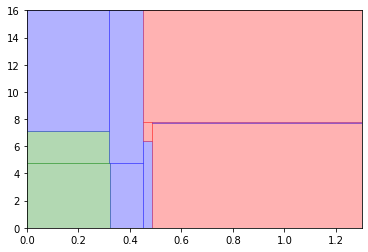

In [135]:
colors = {0: "b", 1: "g", 2: "r"}
for rect in rectangles:
    rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=colors[rect[4]], alpha=0.3)
    plt.gca().add_artist(rp)
plt.xlim(0, 1.3)
plt.ylim(0, 16)

In [136]:
data['data_5']['splitRects']

[{'x1': 0.0, 'x2': 0.45, 'y1': 4.88, 'y2': 0.0, 'prediction': 'cherry'},
 {'x1': 0.0, 'x2': 0.32, 'y1': 7.14, 'y2': 4.88, 'prediction': 'cherry'},
 {'x1': 0.0, 'x2': 0.32, 'y1': 16.0, 'y2': 7.14, 'prediction': 'apple'},
 {'x1': 0.32, 'x2': 0.45, 'y1': 16.0, 'y2': 4.88, 'prediction': 'apple'},
 {'x1': 0.45, 'x2': 1.3, 'y1': 5.41, 'y2': 0.0, 'prediction': 'oak'},
 {'x1': 0.45, 'x2': 1.3, 'y1': 6.01, 'y2': 5.41, 'prediction': 'apple'},
 {'x1': 0.45, 'x2': 1.3, 'y1': 16.0, 'y2': 6.01, 'prediction': 'oak'}]

In [137]:
data['data_5']['treeData']

{'id': '0',
 'children': [{'id': '1',
   'children': [{'id': '2',
     'entropy': '0.16',
     'samples': '43',
     'value': '[ 1. 42.  0.]',
     'class': '1'},
    {'id': '5',
     'children': [{'id': '6',
       'children': [{'id': '7',
         'entropy': '0.98',
         'samples': '12',
         'value': '[5. 7. 0.]',
         'class': '1'},
        {'id': '8',
         'entropy': '0.47',
         'samples': '10',
         'value': '[9. 0. 1.]',
         'class': '0'}],
       'name': 'H ≤ 7.14',
       'entropy': '1.0',
       'samples': '22'},
      {'id': '9',
       'entropy': '0.0',
       'samples': '30',
       'value': '[30.  0.  0.]',
       'class': '0'}],
     'name': 'D ≤ 0.32',
     'entropy': '1.0',
     'samples': '52'}],
   'name': 'H ≤ 4.88',
   'entropy': '1.0',
   'samples': '95'},
  {'id': '10',
   'children': [{'id': '11',
     'children': [{'id': '12',
       'entropy': '0.37',
       'samples': '14',
       'value': '[ 1.  0. 13.]',
       'class': '2'},
 

In [138]:
X = [[d['Diameter'], d["Height"]] for d in data['data_5']['scatterData']]
y = [d['Family'] for d in data['data_5']['scatterData']]
clf = tree.DecisionTreeClassifier(max_depth=4, criterion="entropy")
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

(0.0, 16.0)

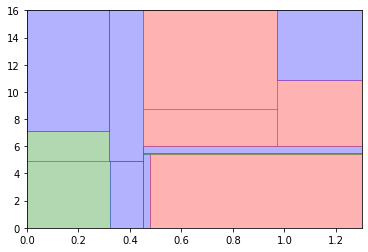

In [139]:
rectangles = decision_areas(clf, maxrange=(0, 1.3, 0, 16))
colors = {0: "b", 1: "g", 2: "r"}
for rect in rectangles:
    rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=colors[rect[4]], alpha=0.3)
    plt.gca().add_artist(rp)
plt.xlim(0, 1.3)
plt.ylim(0, 16)

In [140]:
split_recs_static(clf, class_names)

[{'x1': 0.0, 'x2': 0.32, 'y1': 4.88, 'y2': 0.0, 'prediction': 'cherry'},
 {'x1': 0.32, 'x2': 0.45, 'y1': 4.88, 'y2': 0.0, 'prediction': 'apple'},
 {'x1': 0.0, 'x2': 0.32, 'y1': 7.14, 'y2': 4.88, 'prediction': 'cherry'},
 {'x1': 0.0, 'x2': 0.32, 'y1': 16.0, 'y2': 7.14, 'prediction': 'apple'},
 {'x1': 0.32, 'x2': 0.45, 'y1': 16.0, 'y2': 4.88, 'prediction': 'apple'},
 {'x1': 0.45, 'x2': 0.48, 'y1': 5.41, 'y2': 0.0, 'prediction': 'apple'},
 {'x1': 0.48, 'x2': 1.3, 'y1': 5.41, 'y2': 0.0, 'prediction': 'oak'},
 {'x1': 0.45, 'x2': 1.3, 'y1': 5.5, 'y2': 5.41, 'prediction': 'cherry'},
 {'x1': 0.45, 'x2': 1.3, 'y1': 6.01, 'y2': 5.5, 'prediction': 'apple'},
 {'x1': 0.45, 'x2': 0.97, 'y1': 8.72, 'y2': 6.01, 'prediction': 'oak'},
 {'x1': 0.45, 'x2': 0.97, 'y1': 16.0, 'y2': 8.72, 'prediction': 'oak'},
 {'x1': 0.97, 'x2': 1.3, 'y1': 10.9, 'y2': 6.01, 'prediction': 'oak'},
 {'x1': 0.97, 'x2': 1.3, 'y1': 16.0, 'y2': 10.9, 'prediction': 'apple'}]

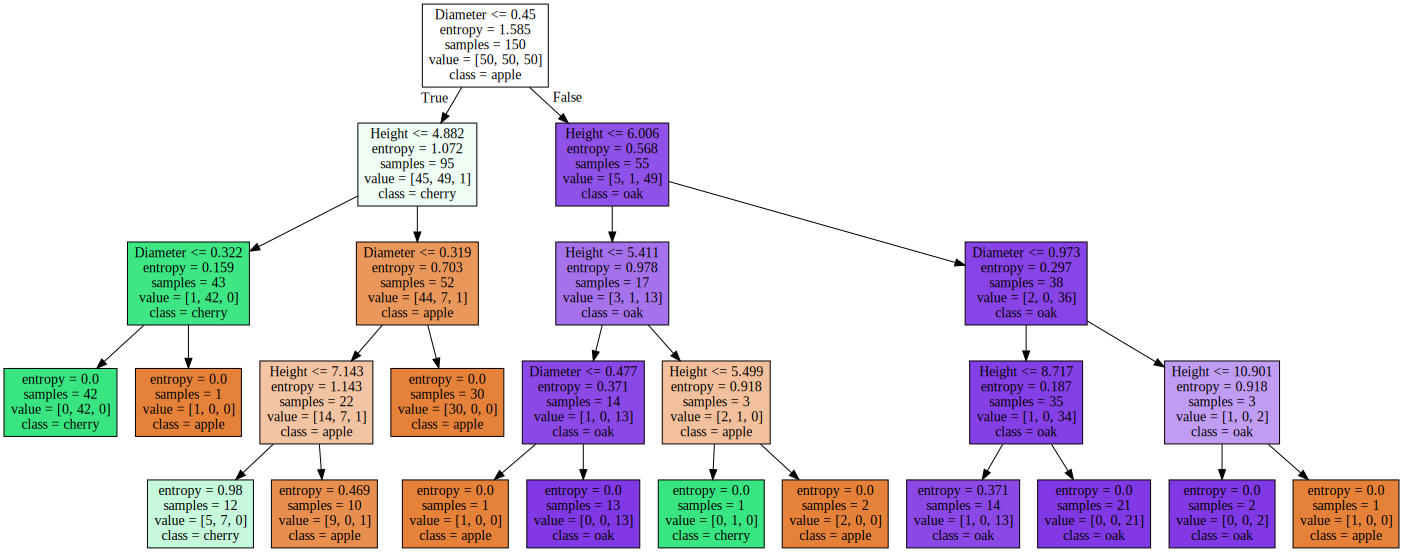

In [141]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=features,  
                                class_names=class_names,
                                filled=True)

# Draw graph - scroll to the right to see the root of the tree
graph = graphviz.Source(dot_data, format="png") 
graph